# Importe de librerías y dataset


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [4]:
#Create the dataframe
dataFrame = pd.read_csv(
    "dataset.csv",
    sep=",",          # separador real
    decimal=".",      # coma decimal → float
    encoding="utf-8", # o "latin-1" si te salieran tildes raras
    low_memory=False  # evita avisos con muchos tipos mezclados
)


dataFrame.head(10)

,Country_of_Origin,Education_Level,Field_of_Study,Language_Proficiency,Visa_Type,Gender,University_Ranking,Region_of_Study,Age,Years_Since_Graduation,GPA,Internship_Experience,Employment_Status,Salary,Job_Sector
0,Vietnam,Bachelor's,IT,Fluent,Permanent Residency,Female,Low,EU,23,8,3.76,Yes,Employed,54397,Healthcare
1,Germany,Master's,Arts,Intermediate,Post-study,Male,High,UK,38,9,3.76,No,Employed,69635,Finance
2,Brazil,PhD,Engineering,Intermediate,Post-study,Male,High,Canada,23,2,3.52,Yes,Employed,96216,Finance
3,Vietnam,PhD,Health,Fluent,Post-study,Female,Medium,Australia,25,5,3.28,Yes,Employed,86076,Other
4,Nigeria,PhD,Engineering,Basic,Student,Male,High,Canada,24,2,3.01,Yes,Employed,82772,Finance
5,Pakistan,Diploma,Engineering,Advanced,Student,Female,Medium,Canada,36,9,2.41,Yes,Employed,28333,Healthcare
6,Brazil,Diploma,Engineering,Fluent,Post-study,Male,Medium,Australia,32,6,2.42,Yes,Unemployed,0,NaN
7,Brazil,Master's,Business,Basic,Student,Female,Medium,Australia,32,7,2.63,No,Continuing Education,0,NaN
8,Vietnam,Master's,Social Sciences,Basic,Student,Female,Medium,UK,29,2,3.66,Yes,Employed,59515,Consulting
9,China,Master's,IT,Fluent,Student,Female,Medium,Australia,38,3,3.31,No,Employed,50604,Education


# Primeros insights

In [6]:
# Veamos los tipos de dato 
dataFrame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Country_of_Origin       300000 non-null  object 
 1   Education_Level         300000 non-null  object 
 2   Field_of_Study          300000 non-null  object 
 3   Language_Proficiency    300000 non-null  object 
 4   Visa_Type               300000 non-null  object 
 5   Gender                  300000 non-null  object 
 6   University_Ranking      300000 non-null  object 
 7   Region_of_Study         300000 non-null  object 
 8   Age                     300000 non-null  int64  
 9   Years_Since_Graduation  300000 non-null  int64  
 10  GPA                     300000 non-null  float64
 11  Internship_Experience   300000 non-null  object 
 12  Employment_Status       300000 non-null  object 
 13  Salary                  300000 non-null  int64  
 14  Job_Sector          

In [7]:
dataFrame.describe()

,Age,Years_Since_Graduation,GPA,Salary
count,300000.000000,300000.000000,300000.000000,300000.000000
mean,30.495950,4.504150,3.200365,30333.692383
std,5.187951,2.874557,0.400285,31791.208938
min,22.000000,0.000000,1.350000,0.000000
25%,26.000000,2.000000,2.930000,0.000000
50%,30.000000,5.000000,3.200000,32296.500000
75%,35.000000,7.000000,3.470000,56634.000000
max,39.000000,9.000000,4.920000,118115.000000


No consideraremos "Visa_Type" ni "Job_Sector"

In [9]:
data = dataFrame

In [10]:
def delete_useless(data: pd.DataFrame)->pd.DataFrame:
    # To delete two useless columns
    return data.drop(columns=['Visa_Type','Job_Sector'])

In [11]:
data1 = delete_useless(data)

In [12]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Country_of_Origin       300000 non-null  object 
 1   Education_Level         300000 non-null  object 
 2   Field_of_Study          300000 non-null  object 
 3   Language_Proficiency    300000 non-null  object 
 4   Gender                  300000 non-null  object 
 5   University_Ranking      300000 non-null  object 
 6   Region_of_Study         300000 non-null  object 
 7   Age                     300000 non-null  int64  
 8   Years_Since_Graduation  300000 non-null  int64  
 9   GPA                     300000 non-null  float64
 10  Internship_Experience   300000 non-null  object 
 11  Employment_Status       300000 non-null  object 
 12  Salary                  300000 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 29.8+ MB


In [13]:
data1['GPA'] = pd.to_numeric(data1['GPA'])

# Variables categóricas


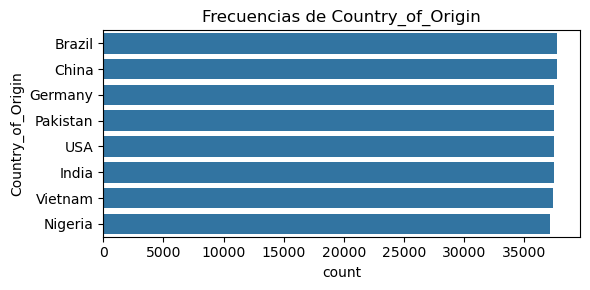

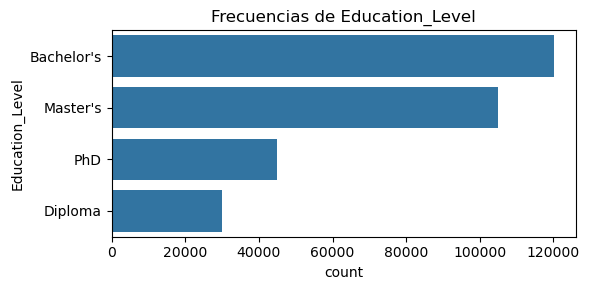

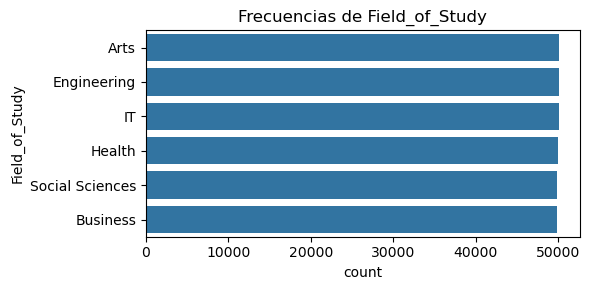

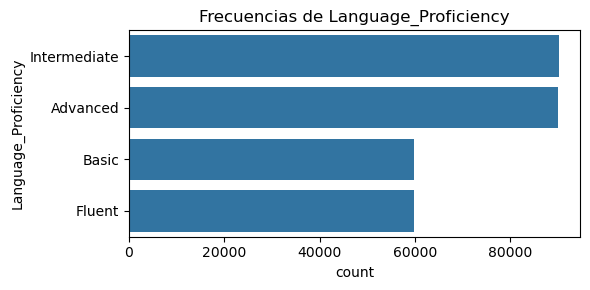

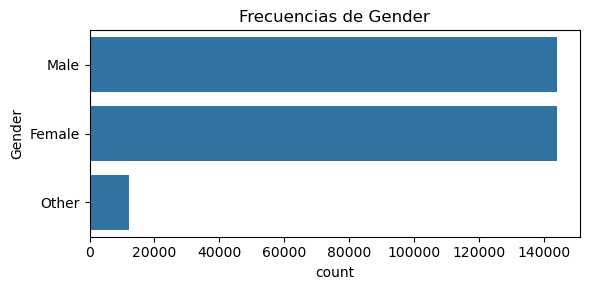

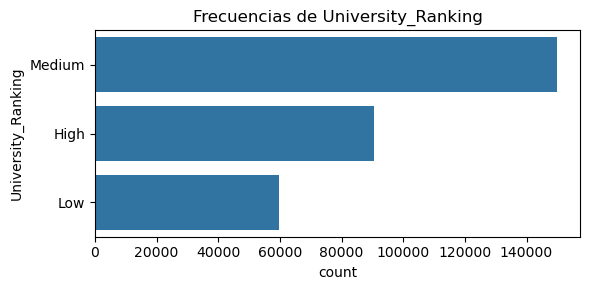

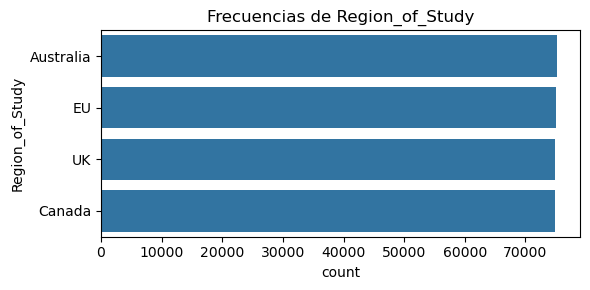

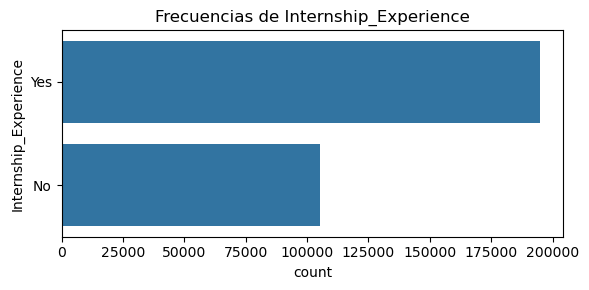

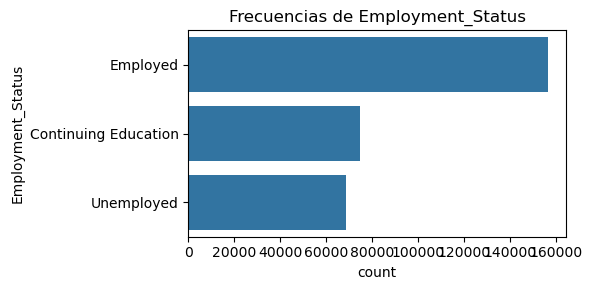

In [15]:
cat_cols = data1.select_dtypes(exclude="number").columns
for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(data=data1, y=col, order=data1[col].value_counts().index)
    plt.title(f"Frecuencias de {col}")
    plt.tight_layout()
    plt.show()

# Variables numéricas

In [17]:


def fd_bins_wide(x: np.ndarray, cap: int = 80, factor: float = 2.0) -> int:
    """
    Número de bins vía Freedman–Diaconis, con bins más anchos.
    'factor' > 1 ⇒ menos bins (más anchos).
    """
    if len(x) == 0:
        return 1
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    bw = factor * (2 * iqr / np.cbrt(len(x)))  # ↑ ancho multiplicado por 'factor'
    if bw == 0:
        return 1
    return int(np.clip(np.ceil((x.max() - x.min()) / bw), 1, cap))


def plot_trimmed_hists(
    df: pd.DataFrame,
    upper_q: float = 0.98,       # recorta por arriba al percentil 98
    lower_q: float = 0.10,       # y por abajo al percentil 10
    cols=None,                   # columnas a dibujar; None = todas numéricas
    n_cols: int = 4,             # nº de columnas en la cuadrícula
    bin_factor: float = 2.0      # factor para ensanchar bins
):
    """
    Dibuja histogramas de variables numéricas con bins más grandes.
    """
    if cols is None:
        cols = df.select_dtypes(include="number").columns
    n_rows = ceil(len(cols) / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4*n_cols, 3*n_rows),
        squeeze=False
    )

    for ax, col in zip(axes.flatten(), cols):
        data = df[col].dropna()
        q_low, q_high = data.quantile([lower_q, upper_q])
        trimmed = data[(data >= q_low) & (data <= q_high)]

        bins = fd_bins_wide(trimmed.to_numpy(), factor=bin_factor)

        ax.hist(trimmed, bins=bins, edgecolor="black")
        ax.set_xlim(q_low, q_high)
        ax.set_title(col)
        ax.set_ylabel("freq")
        ax.ticklabel_format(axis="y", style="plain")

        # Añade texto con % de datos ocultos
        hidden = 100 * (1 - len(trimmed) / len(data))
        if hidden > 0:
            ax.annotate(f"{hidden:.1f}% fuera", xy=(0.97, 0.90),
                        xycoords="axes fraction", ha="right", fontsize=7)

    # Desactiva ejes sobrantes
    for ax in axes.flatten()[len(cols):]:
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


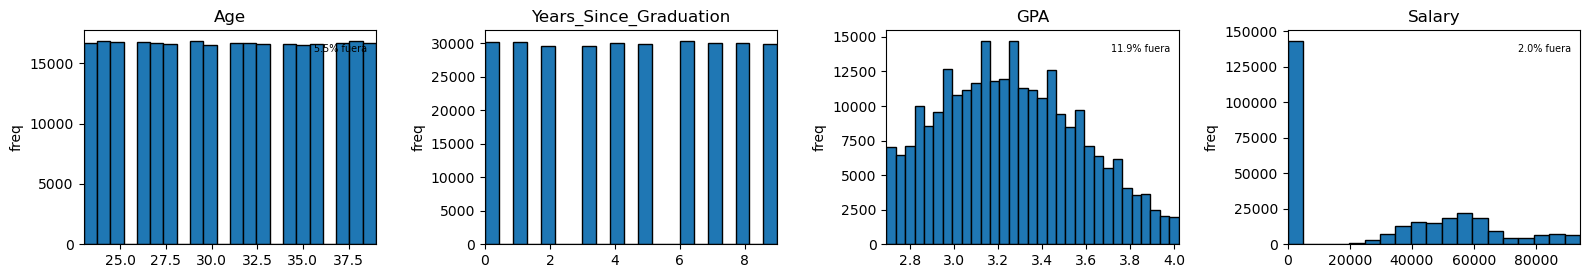

In [18]:
plot_trimmed_hists(data1, bin_factor = 3.0)

In [19]:
variables_numericas = data1.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Variables categóricas
variables_categoricas = data1.select_dtypes(include=['object', 'category']).columns.tolist()

print("Variables numéricas:")
print(variables_numericas)

print("\nVariables categóricas:")
print(variables_categoricas)

Variables numéricas:
['Age', 'Years_Since_Graduation', 'GPA', 'Salary']

Variables categóricas:
['Country_of_Origin', 'Education_Level', 'Field_of_Study', 'Language_Proficiency', 'Gender', 'University_Ranking', 'Region_of_Study', 'Internship_Experience', 'Employment_Status']


# Cambio del dataset

In [24]:
# Pasamos todas las personas de UK a EU para simplificar el entrenamiento

In [26]:
def replace_region(df, col="Region_of_Study", old="UK", new="EU"):
    """
    Reemplaza todos los valores `old` por `new` en la columna `col` del DataFrame `df`.
    Devuelve una copia modificada del DataFrame.
    """
    df_copy = df.copy()
    df_copy[col] = df_copy[col].replace(old, new)
    return df_copy


In [34]:
data1 = replace_region(data1)

In [35]:
# Pasamos la escala de GPA de 0-4 a 0-10

In [36]:
def gpa_to_10(df, col="GPA", new_col="GPA_10"):
    """
    Convierte una columna de GPA en escala 0-4 a una nueva columna en escala 0-10.
    
    Parámetros:
        df (pd.DataFrame): DataFrame de entrada.
        col (str): Nombre de la columna con GPA 0-4.
        new_col (str): Nombre de la columna destino (por defecto 'GPA_10').

    Devuelve:
        pd.DataFrame: Copia del DataFrame con la nueva columna añadida.
    """
    df_copy = df.copy()
    df_copy[new_col] = df_copy[col] * (10 / 4)
    return df_copy


In [37]:
data1 = gpa_to_10(data1)

In [38]:
def remove_zero_salary(df, col="Salary", verbose=True):
    n_before = len(df)
    df_clean = df[df[col] != 0].copy()
    n_after = len(df_clean)
    if verbose:
        print(f"Filas eliminadas: {n_before - n_after} ({(n_before - n_after)/n_before:.2%})")
    return df_clean


In [39]:
data2 = remove_zero_salary(data1)

Filas eliminadas: 143356 (47.79%)


# Primer modelo

In [41]:
def delete_useless2(data: pd.DataFrame)->pd.DataFrame:
    # To delete two useless columns
    return data.drop(columns=['GPA','Employment_Status'])

In [42]:
data3 = delete_useless2(data2)

In [70]:
import pandas as pd

def reducir_dataset(df: pd.DataFrame, n: int = 1000, aleatorio: bool = True, random_state: int = 42) -> pd.DataFrame:
    """
    Devuelve un subconjunto del DataFrame con n filas.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame original.
    n : int, opcional
        Número de filas a conservar (por defecto 40000).
    aleatorio : bool, opcional
        Si True, selecciona filas aleatoriamente; si False, coge las primeras n filas.
    random_state : int, opcional
        Semilla para reproducibilidad si aleatorio=True.

    Retorna
    -------
    pd.DataFrame
        DataFrame reducido.
    """
    if aleatorio:
        return df.sample(n=n, random_state=random_state)
    else:
        return df.head(n)


In [72]:
data4 = reducir_dataset(data3)

In [74]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 164830 to 288060
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country_of_Origin       1000 non-null   object 
 1   Education_Level         1000 non-null   object 
 2   Field_of_Study          1000 non-null   object 
 3   Language_Proficiency    1000 non-null   object 
 4   Gender                  1000 non-null   object 
 5   University_Ranking      1000 non-null   object 
 6   Region_of_Study         1000 non-null   object 
 7   Age                     1000 non-null   int64  
 8   Years_Since_Graduation  1000 non-null   int64  
 9   Internship_Experience   1000 non-null   object 
 10  Salary                  1000 non-null   int64  
 11  GPA_10                  1000 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 101.6+ KB


In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# X, y
X = data4.drop(columns=['Salary'])
y = data4['Salary']

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Pipelines de preprocesado (sin escalar para árboles; imputamos por seguridad)
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Agrupa categorías raras para no explotar el nº de columnas:
    ('ohe', OneHotEncoder(handle_unknown='ignore',
                          sparse_output=True,
                          min_frequency=0.01))  # o usa max_categories=50
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    # ('scaler', StandardScaler(with_mean=False))  # opcional; no necesario para árboles
])

pre = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
], remainder='drop')

reg = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

model = Pipeline([
    ('pre', pre),
    ('reg', reg)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R² test:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R² test: 0.9186209079034358
MAE: 4121.5598375


In [80]:
import joblib

def guardar_modelo(modelo, nombre_archivo: str = "modelo_entrenado.pkl"):
    """
    Guarda un modelo entrenado en un archivo .pkl usando joblib.

    Parámetros
    ----------
    modelo : objeto entrenado (por ejemplo, Pipeline o estimador de scikit-learn)
        El modelo ya entrenado que quieres guardar.
    nombre_archivo : str, opcional
        Nombre del archivo de salida (por defecto 'modelo_entrenado.pkl').
    """
    joblib.dump(modelo, nombre_archivo)
    print(f"✅ Modelo guardado correctamente en: {nombre_archivo}")


In [82]:
guardar_modelo(model, "modelo_salary.pkl")

✅ Modelo guardado correctamente en: modelo_salary.pkl
